This jupyter notebook is the finial pipeline to control the arm grasping object to measure the overall performance. Steps are as following:
- First, this pipeline generates initial state images at 7 angels detailed in dissertation. 
- Second, use VAE to encode the initial state images and get the latent space.
- Third, use regression model to regress the latent space to position and orientation of end effector.
- Forth, move the end effector to the target positioin.
- Fifth, grasp and retrat the obejct to a random space and finish.

Each part detials as following:
- 'Initialize' part: import relevent library and check library version. Run the helper functions.
- 'RGB' version: the pipeline uses RGB type of image to grasp. VAE and regression is RGB version as well.
- 'Depth' version: the pipeline uses Depth image to grasp. VAE and regression is Depth version.
- 'RGBD' version: the pipeline uses RGBD image, first needs to combine RGB and depth image to form RGBD image. VAE and regression is RGBD version.

At the end of RGB, Depth, and RGBD version part, calculate the overall success rate over 1000 attemps. Compare the result in 'Compare' part.

# Initialize

In [2]:
#Imports - Pybullet
import pybullet as p
import pybullet_data

#Imports - Pytorch
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data as Data

import torchvision
from torchvision import transforms
import torchvision.datasets as dst
import torchvision.transforms.functional as TF
from torchvision.utils import save_image, make_grid

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Imports - Others
import math
import random
import time
import shutil
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Check torch and torchvision version
# Torch verison used are 1.6.0
# Torchvision version used are 0.7.0
# If version doesn't mathch, may occur error when load trained VAE and regression models


print('Torch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)

#If not
# !pip uninstall torch
# !pip uninstall torchvision
# !pip install torchvision==0.7.0
# !pip install torch==1.6.0

Torch version: 1.6.0
Torchvision version: 0.7.0


In [3]:
#Parameters for kuka
maxVelocity = .35
maxForce = 200.
fingerAForce = 2.5
fingerBForce = 2.5
fingerTipForce = 2.5

kukaEndEffectorIndex = 6
kukaGripperIndex = 7

endEffectorPos = [0.537, 0.0, 0.5]
endEffectorAngle = 0

In [4]:
# This helper function is used to reset the kuka arm to the initial state. 

def resetKukaArm(kukaUid):
    
    
    p.resetBasePositionAndOrientation(kukaUid, [-0.100000, 0.000000, 0.070000],
                                      [0.000000, 0.000000, 0.000000, 1.000000])
    
    # Initial joint positions.
    jointPositions = [0.006418, 0.413184, -0.011401, -1.589317, 0.005379, 1.137684, -0.006539, 
                  0.000048,-0.299912, 0.000000, -0.000043, 0.299960, 0.000000, -0.000200]
    
    #Set Initial position for gripper
    numJoints = p.getNumJoints(kukaUid)

    #Option 1: 
    for jointIndex in range(numJoints):
        p.resetJointState(kukaUid, jointIndex, jointPositions[jointIndex])
        p.setJointMotorControl2(kukaUid,
                                jointIndex,
                                p.POSITION_CONTROL,
                                targetPosition=jointPositions[jointIndex],
                                force=maxForce)
        
    
    for i in range (50):
        p.stepSimulation()
        #time.sleep(1./240)
        
# Initial the environment (plane, table and the kuka arm)
def resetEnv():
    #Reset GUI
    p.resetSimulation()

    #p.loadURDF("plane.urdf", [0, 0, -1])

    p.loadURDF("table/table.urdf", 0.5000000, 0.00000, -.820000, 0.000000, 0.000000, 0.0, 1.0)

    #Set Gravity
    p.setGravity(0, 0, -10)
    kukaUid = p.loadSDF("kuka_iiwa/kuka_with_gripper2.sdf")
    kukaUid = kukaUid[0]
    
    #Run reset Function
    resetKukaArm(kukaUid)    
    
    return kukaUid

# Set random object, return real position of the object
def setRandomObject():
    # Set objects
    xpos = 0.4 + 0.25 * random.random()
    ypos = 0 + 0.3 * random.random()
    ang = 3.14 * 0.5 + 3.14 * random.random() /3
    orn = p.getQuaternionFromEuler([0, 0, ang])
    blockUid = p.loadURDF("block.urdf", xpos, ypos, -0.18, orn[0], orn[1], orn[2], orn[3])

    #small, kuka cannot hold
    #blockUid = p.loadURDF("cube_small.urdf", xpos, ypos, -0.18, orn[0], orn[1], orn[2], orn[3]) 

    #print(xpos, ypos, "-0.18", orn)
    
    #Let the object fall for a while
    for i in range (10):
        p.stepSimulation()
    
    #get object position and orientation
    blockPos, blockOrn = p.getBasePositionAndOrientation(blockUid)
    blockEuler = p.getEulerFromQuaternion(blockOrn)
#     print('blockPos', blockPos)
#     print('blockOrn', blockEuler)
    
    return blockUid, blockPos, blockEuler

In [6]:
# Apply action uses the returend position from regression.

def moveGripper(kukaUid, endEffectorPos):
    numJoints = p.getNumJoints(kukaUid)

    #joint damping coefficents
    jd = [0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 
          0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001]


    pos = endEffectorPos
    orn = p.getQuaternionFromEuler([0, -math.pi, 0])  # -math.pi,yaw])
    
    #Calculate joint angle using Inverse Kinematics
    jointPoses = p.calculateInverseKinematics(kukaUid,
                                              kukaEndEffectorIndex,
                                              pos,
                                              orn,
                                              jointDamping=jd) #jointDamping
    #Set angle to joints
    for i in range(kukaEndEffectorIndex + 1):
        #print(i)
        p.setJointMotorControl2(bodyUniqueId=kukaUid,
                                jointIndex=i,
                                controlMode=p.POSITION_CONTROL,
                                targetPosition=jointPoses[i],
                                targetVelocity=0,
                                force=maxForce,
                                maxVelocity=maxVelocity,
                                positionGain=0.3,
                                velocityGain=1)
    
    for i in range (1000):
        p.stepSimulation()
        #time.sleep(1./240)

In [7]:
# Grasp, closes the fingers
def attmptGrasp(kukaUid):
    finger_angle = 0.3
    endEffectorAngle = 0
    fingerAngle = 0
    for _ in range(500):
        #fingers
        p.setJointMotorControl2(kukaUid,
                                7,
                                p.POSITION_CONTROL,
                                targetPosition=endEffectorAngle,
                                force=maxForce)
        p.setJointMotorControl2(kukaUid,
                                8,
                                p.POSITION_CONTROL,
                                targetPosition=-fingerAngle,
                                force=fingerAForce)
        p.setJointMotorControl2(kukaUid,
                                11,
                                p.POSITION_CONTROL,
                                targetPosition=fingerAngle,
                                force=fingerBForce)

        p.setJointMotorControl2(kukaUid,
                                10,
                                p.POSITION_CONTROL,
                                targetPosition=0,
                                force=fingerTipForce)
        p.setJointMotorControl2(kukaUid,
                                13,
                                p.POSITION_CONTROL,
                                targetPosition=0,
                                force=fingerTipForce)
        p.stepSimulation()
        #time.sleep(timeStep)
        
        finger_angle -= 0.3 / 100.
        if finger_angle < 0:
            finger_angle = 0

In [8]:
# Retract the object to a random position near the initial position
def retractObjetc(kukaUid):
    kukaEndEffectorIndex = 6
    orn = p.getQuaternionFromEuler([0, -math.pi, 0])
    xpos = 0.15 + 0.3 * random.random()
    ypos = 0.1 + 0.3 * random.random()
    pos = [xpos, ypos, 0.5]
    
    jd = [0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 
          0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001]
    
    jointPoses = p.calculateInverseKinematics(kukaUid,
                                              kukaEndEffectorIndex,
                                              pos,
                                              orn,
                                              jointDamping=jd) #jointDamping

    for i in range(kukaEndEffectorIndex + 1):
        #print(i)
        p.setJointMotorControl2(bodyUniqueId=kukaUid,
                                jointIndex=i,
                                controlMode=p.POSITION_CONTROL,
                                targetPosition=jointPoses[i],
                                targetVelocity=0,
                                force=maxForce,
                                maxVelocity=maxVelocity,
                                positionGain=0.3,
                                velocityGain=1)
    
    for i in range (1000):
        p.stepSimulation()
        #time.sleep(1./240)

In [9]:
# getCameraImage, get image data for initial state
def render(kukaUid, blockUid, cam_dist, cam_yaw, cam_pitch, camPos):
    
    RENDER_HEIGHT = 64
    RENDER_WIDTH = 64
    
#     camPos = (0.525, 0.15, -0.186)
    #cam_dist = 1.0
#     cam_yaw = 180
#     cam_pitch = -40

    #base_pos, orn = p.getBasePositionAndOrientation(kukaUid)
    #base_pos: (-0.1, 0, 0.07)
    
    blockPos, _ = p.getBasePositionAndOrientation(blockUid)
    
    view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition = blockPos,
                                                      distance = cam_dist,
                                                      yaw = cam_yaw,
                                                      pitch = cam_pitch,
                                                      roll = 0,
                                                      upAxisIndex = 2)

    proj_matrix = p.computeProjectionMatrixFOV(fov=60,
                                               aspect=float(RENDER_WIDTH) / RENDER_HEIGHT,
                                               nearVal=0.1,
                                               farVal=100.0)

    (_, _, rgb_px, depth_px, _) = p.getCameraImage(width=RENDER_WIDTH,
                                                   height=RENDER_HEIGHT,
                                                   viewMatrix=view_matrix,
                                                   projectionMatrix=proj_matrix,
                                                   renderer=p.ER_BULLET_HARDWARE_OPENGL)
                                                   #renderer=p.ER_TINY_RENDERER #Direct mode)

    rgb_array = np.array(rgb_px, dtype=np.uint8)
    rgb_array = np.reshape(rgb_array, (RENDER_HEIGHT, RENDER_WIDTH, 4))
    rgb_array = rgb_array[:, :, :3]

    depth_array = np.array(depth_px)
    
    return rgb_array, depth_array

In [10]:
# class for the VAE, for all version of VAE
class VAE(nn.Module):

    def __init__(self, in_channels, latent_dim, hidden_dims = None):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        img_channels = in_channels

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]* 4 * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]* 4 * 4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4 * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= img_channels,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, 4, 4) #2*2
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self, num_samples, current_device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]
    
# Citation:
#
# @misc{Subramanian2020,
#   author = {Subramanian, A.K},
#   title = {PyTorch-VAE},
#   year = {2020},
#   publisher = {GitHub},
#   journal = {GitHub repository},
#   howpublished = {\url{https://github.com/AntixK/PyTorch-VAE}}
# }

In [11]:
# Regression model for all version

class regressionNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(regressionNet, self).__init__()
        
        self.layer1 = nn.Linear(in_dim, out_dim)
 
    def forward(self, x):
        x = self.layer1(x)
        return x

# RGB version

In [12]:
#Load trained VAE
vae_rgb = VAE(3, 128).to(device)
vae_rgb.load_state_dict(torch.load(
    "VAE_result_RGB_v3_BasedOn7OriImg/VAE_result_appro/VAE_500EPOCH.pkl", 
    map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
#Load trained Regression
regression_rgb = regressionNet(in_dim = 256, out_dim = 7).to(device)
regression_rgb.load_state_dict(torch.load("regressionResult/RGB_v2_7-dim/Regression_appro_500_bak.pkl"))

<All keys matched successfully>

In [14]:
#Initial the pybullet environment
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
#Set Camera angles
p.resetDebugVisualizerCamera(
    cameraDistance = 2.5, 
    cameraYaw = 180,
    cameraPitch = -42,
    cameraTargetPosition = [0.52, -0.2, -0.33]#Camara focus position, on gripper
)

In [15]:
#pipeline try only one angle image
win = 0
for i in range(2000):
    
    #initial kuka and object
    kukaUid = resetEnv()
    blockUid, blockPos, blockEuler = setRandomObject()
    
    #get initial state images
    rgb_initial1, _ = render(kukaUid, blockUid, 1, 0, -50, 0)
    rgb_initial2, _ = render(kukaUid, blockUid, 1, 45, -50, 0)
    rgb_initial3, _ = render(kukaUid, blockUid, 1, 90, -50, 0)
    rgb_initial4, _ = render(kukaUid, blockUid, 1, 135, -50, 0)
    rgb_initial5, _ = render(kukaUid, blockUid, 1, 180, -50, 0)
    rgb_initial6, _ = render(kukaUid, blockUid, 1, 225, -50, 0)
    rgb_initial7, _ = render(kukaUid, blockUid, 0.8, 270, -50, 0)

    rgb_tensor1 = TF.to_tensor(rgb_initial1)
    rgb_tensor2 = TF.to_tensor(rgb_initial2)
    rgb_tensor3 = TF.to_tensor(rgb_initial3)
    rgb_tensor4 = TF.to_tensor(rgb_initial4)
    rgb_tensor5 = TF.to_tensor(rgb_initial5)
    rgb_tensor6 = TF.to_tensor(rgb_initial6)
    rgb_tensor7 = TF.to_tensor(rgb_initial7)
    
    #formalize the tensor array for VAE
    rgb_tensor = torch.stack((rgb_tensor1, rgb_tensor2, rgb_tensor3, 
                              rgb_tensor4, rgb_tensor5, rgb_tensor6, 
                              rgb_tensor7), dim = 0)
    
    #Use trained VAE to get the encode initial state images
    vae_result = vae_rgb.encode(rgb_tensor)
    vae_result_regression = torch.cat((vae_result[0], vae_result[1]), dim = 1)
    vae_result_regression = vae_result_regression.data
    
    #Use the encoded latent spce to regress the position
    re = regression_rgb(vae_result_regression)
    
    #Move the end effector to the tartget position. The z value is fixed.
    moveGripper(kukaUid, [re[0][0].item(), re[0][1].item(), 0.09])
    
    #Grasp and retract the object.
    attmptGrasp(kukaUid)
    retractObjetc(kukaUid)
    
    #see if the grasp success according to the vertical displacement of object.
    if p.getBasePositionAndOrientation(blockUid)[0][2] > -0.1:
        print("Approach ", i, 'sucess.')
        win += 1

Approach  3 sucess.
Approach  5 sucess.
Approach  9 sucess.
Approach  12 sucess.
Approach  22 sucess.
Approach  25 sucess.
Approach  34 sucess.
Approach  38 sucess.
Approach  43 sucess.
Approach  47 sucess.
Approach  49 sucess.
Approach  50 sucess.
Approach  54 sucess.
Approach  55 sucess.
Approach  59 sucess.
Approach  62 sucess.
Approach  67 sucess.
Approach  68 sucess.
Approach  74 sucess.
Approach  75 sucess.
Approach  79 sucess.
Approach  89 sucess.
Approach  90 sucess.
Approach  97 sucess.
Approach  106 sucess.
Approach  107 sucess.
Approach  111 sucess.
Approach  113 sucess.
Approach  118 sucess.
Approach  124 sucess.
Approach  135 sucess.
Approach  142 sucess.
Approach  151 sucess.
Approach  156 sucess.
Approach  159 sucess.
Approach  165 sucess.
Approach  171 sucess.
Approach  172 sucess.
Approach  177 sucess.
Approach  178 sucess.
Approach  180 sucess.
Approach  181 sucess.
Approach  185 sucess.
Approach  190 sucess.
Approach  214 sucess.
Approach  219 sucess.
Approach  225 s

In [16]:
print("RGB version sucess rate: ", win/2000)

RGB version sucess rate:  0.175


In [17]:
win

350

In [15]:
#pipeline Try every orientation image, mostly same as above
win_list = []
for ori in range(7):
    win = 0
    print("Use Img Ori", ori)
    for i in range(1000):
        kukaUid = resetEnv()
        blockUid, blockPos, blockEuler = setRandomObject()
        rgb_initial1, _ = render(kukaUid, blockUid, 1, 0, -50, 0)
        rgb_initial2, _ = render(kukaUid, blockUid, 1, 45, -50, 0)
        rgb_initial3, _ = render(kukaUid, blockUid, 1, 90, -50, 0)
        rgb_initial4, _ = render(kukaUid, blockUid, 1, 135, -50, 0)
        rgb_initial5, _ = render(kukaUid, blockUid, 1, 180, -50, 0)
        rgb_initial6, _ = render(kukaUid, blockUid, 1, 225, -50, 0)
        rgb_initial7, _ = render(kukaUid, blockUid, 0.8, 270, -50, 0)

        rgb_tensor1 = TF.to_tensor(rgb_initial1)
        rgb_tensor2 = TF.to_tensor(rgb_initial2)
        rgb_tensor3 = TF.to_tensor(rgb_initial3)
        rgb_tensor4 = TF.to_tensor(rgb_initial4)
        rgb_tensor5 = TF.to_tensor(rgb_initial5)
        rgb_tensor6 = TF.to_tensor(rgb_initial6)
        rgb_tensor7 = TF.to_tensor(rgb_initial7)

        rgb_tensor = torch.stack((rgb_tensor1, rgb_tensor2, rgb_tensor3, 
                                  rgb_tensor4, rgb_tensor5, rgb_tensor6, 
                                  rgb_tensor7), dim = 0)

        vae_result = vae_rgb.encode(rgb_tensor)
        vae_result_regression = torch.cat((vae_result[0], vae_result[1]), dim = 1)
        vae_result_regression = vae_result_regression.data

        re = regression_rgb(vae_result_regression)

        moveGripper(kukaUid, [re[ori][0].item(), re[ori][1].item(), 0.09])
        attmptGrasp(kukaUid)
        retractObjetc(kukaUid)

        if p.getBasePositionAndOrientation(blockUid)[0][2] > -0.1:
            print("Approach ", i, 'sucess.')
            win += 1
    
    win_list.append(win)

Use Img Ori 0
Approach  4 sucess.
Approach  5 sucess.
Approach  8 sucess.
Approach  9 sucess.
Approach  10 sucess.
Approach  21 sucess.
Approach  31 sucess.
Approach  33 sucess.
Approach  34 sucess.
Approach  39 sucess.
Approach  51 sucess.
Approach  57 sucess.
Approach  60 sucess.
Approach  61 sucess.
Approach  72 sucess.
Approach  80 sucess.
Approach  89 sucess.
Approach  90 sucess.
Approach  93 sucess.
Approach  100 sucess.
Approach  101 sucess.
Approach  102 sucess.
Approach  107 sucess.
Approach  114 sucess.
Approach  120 sucess.
Approach  129 sucess.
Approach  130 sucess.
Approach  133 sucess.
Approach  134 sucess.
Approach  136 sucess.
Approach  142 sucess.
Approach  150 sucess.
Approach  151 sucess.
Approach  160 sucess.
Approach  161 sucess.
Approach  169 sucess.
Approach  188 sucess.
Approach  190 sucess.
Approach  191 sucess.
Approach  194 sucess.
Approach  202 sucess.
Approach  210 sucess.
Approach  211 sucess.
Approach  212 sucess.
Approach  214 sucess.
Approach  215 suces

Approach  845 sucess.
Approach  853 sucess.
Approach  858 sucess.
Approach  862 sucess.
Approach  863 sucess.
Approach  871 sucess.
Approach  872 sucess.
Approach  874 sucess.
Approach  875 sucess.
Approach  880 sucess.
Approach  881 sucess.
Approach  890 sucess.
Approach  894 sucess.
Approach  903 sucess.
Approach  916 sucess.
Approach  925 sucess.
Approach  926 sucess.
Approach  931 sucess.
Approach  935 sucess.
Approach  943 sucess.
Approach  945 sucess.
Approach  947 sucess.
Approach  948 sucess.
Approach  950 sucess.
Approach  960 sucess.
Approach  962 sucess.
Approach  964 sucess.
Approach  972 sucess.
Approach  976 sucess.
Approach  979 sucess.
Approach  983 sucess.
Approach  986 sucess.
Approach  988 sucess.
Approach  995 sucess.
Approach  996 sucess.
Approach  999 sucess.
Use Img Ori 2
Approach  2 sucess.
Approach  4 sucess.
Approach  5 sucess.
Approach  10 sucess.
Approach  18 sucess.
Approach  27 sucess.
Approach  31 sucess.
Approach  38 sucess.
Approach  42 sucess.
Approach

Approach  279 sucess.
Approach  280 sucess.
Approach  283 sucess.
Approach  287 sucess.
Approach  288 sucess.
Approach  292 sucess.
Approach  295 sucess.
Approach  296 sucess.
Approach  301 sucess.
Approach  302 sucess.
Approach  303 sucess.
Approach  304 sucess.
Approach  309 sucess.
Approach  317 sucess.
Approach  321 sucess.
Approach  329 sucess.
Approach  331 sucess.
Approach  332 sucess.
Approach  334 sucess.
Approach  337 sucess.
Approach  344 sucess.
Approach  345 sucess.
Approach  347 sucess.
Approach  348 sucess.
Approach  354 sucess.
Approach  360 sucess.
Approach  361 sucess.
Approach  362 sucess.
Approach  367 sucess.
Approach  371 sucess.
Approach  383 sucess.
Approach  384 sucess.
Approach  388 sucess.
Approach  389 sucess.
Approach  393 sucess.
Approach  398 sucess.
Approach  403 sucess.
Approach  406 sucess.
Approach  409 sucess.
Approach  416 sucess.
Approach  422 sucess.
Approach  426 sucess.
Approach  435 sucess.
Approach  436 sucess.
Approach  439 sucess.
Approach  

Approach  280 sucess.
Approach  291 sucess.
Approach  299 sucess.
Approach  300 sucess.
Approach  303 sucess.
Approach  313 sucess.
Approach  318 sucess.
Approach  320 sucess.
Approach  326 sucess.
Approach  329 sucess.
Approach  332 sucess.
Approach  334 sucess.
Approach  352 sucess.
Approach  354 sucess.
Approach  356 sucess.
Approach  364 sucess.
Approach  381 sucess.
Approach  386 sucess.
Approach  390 sucess.
Approach  399 sucess.
Approach  407 sucess.
Approach  408 sucess.
Approach  410 sucess.
Approach  413 sucess.
Approach  425 sucess.
Approach  426 sucess.
Approach  448 sucess.
Approach  461 sucess.
Approach  469 sucess.
Approach  505 sucess.
Approach  506 sucess.
Approach  508 sucess.
Approach  531 sucess.
Approach  532 sucess.
Approach  534 sucess.
Approach  542 sucess.
Approach  545 sucess.
Approach  557 sucess.
Approach  564 sucess.
Approach  565 sucess.
Approach  574 sucess.
Approach  575 sucess.
Approach  589 sucess.
Approach  591 sucess.
Approach  599 sucess.
Approach  

In [16]:
print(win_list)

[188, 222, 263, 259, 136, 167, 159]


In [18]:
print(np.array(win_list)/1000)

[0.188 0.222 0.263 0.259 0.136 0.167 0.159]


# Depth version

In [12]:
#Load trained Depth VAE
vae_depth = VAE(1, 256).to(device)
vae_depth.load_state_dict(torch.load(
    "VAE_result_DepthImg_v1/VAE_result_depth_appro/VAE_800EPOCH.pkl", 
    map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
#Load trained Regression
regression_depth = regressionNet(in_dim = 512, out_dim = 7).to(device)
regression_depth.load_state_dict(torch.load("regressionResult/Depth/Regression_depth_500.pkl"))

<All keys matched successfully>

In [14]:
p.connect(p.DIRECT)
# p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
#Set Camera angles
p.resetDebugVisualizerCamera(
    cameraDistance = 2.5, 
    cameraYaw = 180, #左右仰角
    cameraPitch = -42, #上下仰角 
    cameraTargetPosition = [0.52, -0.2, -0.33]#Camara focus position, on gripper
)

In [17]:
win = 0
for i in range(2000):
    kukaUid = resetEnv()
    blockUid, blockPos, blockEuler = setRandomObject()
    _, depth_initial1 = render(kukaUid, blockUid, 1, 0, -50, 0)
    _, depth_initial2 = render(kukaUid, blockUid, 1, 45, -50, 0)
    _, depth_initial3 = render(kukaUid, blockUid, 1, 90, -50, 0)
    _, depth_initial4 = render(kukaUid, blockUid, 1, 135, -50, 0)
    _, depth_initial5 = render(kukaUid, blockUid, 1, 180, -50, 0)
    _, depth_initial6 = render(kukaUid, blockUid, 1, 225, -50, 0)
    _, depth_initial7 = render(kukaUid, blockUid, 0.8, 270, -50, 0)

    depth_tensor1 = torch.tensor(depth_initial1.reshape(1,64,64), dtype = torch.float32)
    depth_tensor2 = torch.tensor(depth_initial2.reshape(1,64,64), dtype = torch.float32)
    depth_tensor3 = torch.tensor(depth_initial3.reshape(1,64,64), dtype = torch.float32)
    depth_tensor4 = torch.tensor(depth_initial4.reshape(1,64,64), dtype = torch.float32)
    depth_tensor5 = torch.tensor(depth_initial5.reshape(1,64,64), dtype = torch.float32)
    depth_tensor6 = torch.tensor(depth_initial6.reshape(1,64,64), dtype = torch.float32)
    depth_tensor7 = torch.tensor(depth_initial7.reshape(1,64,64), dtype = torch.float32)

    depth_tensor = torch.stack((depth_tensor1, depth_tensor2, depth_tensor3, 
                                depth_tensor4, depth_tensor5, depth_tensor6, 
                                depth_tensor7), dim = 0)

    vae_result = vae_depth.encode(depth_tensor)
    vae_result_regression = torch.cat((vae_result[0], vae_result[1]), dim = 1)
    vae_result_regression = vae_result_regression.data

    re = regression_depth(vae_result_regression)

    moveGripper(kukaUid, [re[6][0].item(), re[6][1].item(), 0.09])

    attmptGrasp(kukaUid)
    retractObjetc(kukaUid)

    if p.getBasePositionAndOrientation(blockUid)[0][2] > -0.1:
        print("Approach ", i, 'success.')
        win += 1

Approach  9 sucess.
Approach  10 sucess.
Approach  13 sucess.
Approach  29 sucess.
Approach  47 sucess.
Approach  56 sucess.
Approach  60 sucess.
Approach  66 sucess.
Approach  76 sucess.
Approach  99 sucess.
Approach  108 sucess.
Approach  118 sucess.
Approach  140 sucess.
Approach  161 sucess.
Approach  175 sucess.
Approach  176 sucess.
Approach  199 sucess.
Approach  211 sucess.
Approach  215 sucess.
Approach  224 sucess.
Approach  243 sucess.
Approach  244 sucess.
Approach  304 sucess.
Approach  326 sucess.
Approach  336 sucess.
Approach  366 sucess.
Approach  434 sucess.
Approach  444 sucess.
Approach  445 sucess.
Approach  446 sucess.
Approach  459 sucess.
Approach  461 sucess.
Approach  470 sucess.
Approach  472 sucess.
Approach  476 sucess.
Approach  487 sucess.
Approach  489 sucess.
Approach  490 sucess.
Approach  500 sucess.
Approach  505 sucess.
Approach  507 sucess.
Approach  522 sucess.
Approach  523 sucess.
Approach  528 sucess.
Approach  547 sucess.
Approach  550 sucess.

In [19]:
print("Total success number:", win)
print("Depth version success rate: ", win/2000)

Total success number: 206
Depth version success rate:  0.103


In [15]:
# Try every orientation image
win_list = []
for ori in range(7):
    win = 0
    print("Use Img Ori", ori)
    for i in range(1000):
        kukaUid = resetEnv()
        blockUid, blockPos, blockEuler = setRandomObject()
        _, depth_initial1 = render(kukaUid, blockUid, 1, 0, -50, 0)
        _, depth_initial2 = render(kukaUid, blockUid, 1, 45, -50, 0)
        _, depth_initial3 = render(kukaUid, blockUid, 1, 90, -50, 0)
        _, depth_initial4 = render(kukaUid, blockUid, 1, 135, -50, 0)
        _, depth_initial5 = render(kukaUid, blockUid, 1, 180, -50, 0)
        _, depth_initial6 = render(kukaUid, blockUid, 1, 225, -50, 0)
        _, depth_initial7 = render(kukaUid, blockUid, 0.8, 270, -50, 0)

        depth_tensor1 = torch.tensor(depth_initial1.reshape(1,64,64), dtype = torch.float32)
        depth_tensor2 = torch.tensor(depth_initial2.reshape(1,64,64), dtype = torch.float32)
        depth_tensor3 = torch.tensor(depth_initial3.reshape(1,64,64), dtype = torch.float32)
        depth_tensor4 = torch.tensor(depth_initial4.reshape(1,64,64), dtype = torch.float32)
        depth_tensor5 = torch.tensor(depth_initial5.reshape(1,64,64), dtype = torch.float32)
        depth_tensor6 = torch.tensor(depth_initial6.reshape(1,64,64), dtype = torch.float32)
        depth_tensor7 = torch.tensor(depth_initial7.reshape(1,64,64), dtype = torch.float32)

        depth_tensor = torch.stack((depth_tensor1, depth_tensor2, depth_tensor3, 
                                    depth_tensor4, depth_tensor5, depth_tensor6, 
                                    depth_tensor7), dim = 0)

        vae_result = vae_depth.encode(depth_tensor)
        vae_result_regression = torch.cat((vae_result[0], vae_result[1]), dim = 1)
        vae_result_regression = vae_result_regression.data

        re = regression_depth(vae_result_regression)

        moveGripper(kukaUid, [re[6][0].item(), re[6][1].item(), 0.09])

        attmptGrasp(kukaUid)
        retractObjetc(kukaUid)

        if p.getBasePositionAndOrientation(blockUid)[0][2] > -0.1:
            print("Approach ", i, 'success.')
            win += 1
        
    win_list.append(win)
    

Use Img Ori 0
Approach  3 success.
Approach  22 success.
Approach  32 success.
Approach  45 success.
Approach  60 success.
Approach  72 success.
Approach  76 success.
Approach  80 success.
Approach  101 success.
Approach  102 success.
Approach  104 success.
Approach  114 success.
Approach  119 success.
Approach  132 success.
Approach  144 success.
Approach  147 success.
Approach  148 success.
Approach  151 success.
Approach  153 success.
Approach  159 success.
Approach  187 success.
Approach  196 success.
Approach  199 success.
Approach  210 success.
Approach  217 success.
Approach  229 success.
Approach  232 success.
Approach  252 success.
Approach  255 success.
Approach  269 success.
Approach  273 success.
Approach  291 success.
Approach  294 success.
Approach  320 success.
Approach  321 success.
Approach  338 success.
Approach  361 success.
Approach  364 success.
Approach  378 success.
Approach  381 success.
Approach  388 success.
Approach  393 success.
Approach  397 success.
Approa

Approach  212 success.
Approach  213 success.
Approach  219 success.
Approach  242 success.
Approach  254 success.
Approach  257 success.
Approach  269 success.
Approach  273 success.
Approach  287 success.
Approach  306 success.
Approach  307 success.
Approach  315 success.
Approach  333 success.
Approach  345 success.
Approach  347 success.
Approach  350 success.
Approach  351 success.
Approach  352 success.
Approach  358 success.
Approach  366 success.
Approach  367 success.
Approach  368 success.
Approach  373 success.
Approach  383 success.
Approach  384 success.
Approach  390 success.
Approach  408 success.
Approach  418 success.
Approach  436 success.
Approach  458 success.
Approach  459 success.
Approach  463 success.
Approach  472 success.
Approach  484 success.
Approach  495 success.
Approach  497 success.
Approach  541 success.
Approach  543 success.
Approach  559 success.
Approach  567 success.
Approach  571 success.
Approach  577 success.
Approach  601 success.
Approach  6

Approach  750 success.
Approach  763 success.
Approach  766 success.
Approach  769 success.
Approach  783 success.
Approach  786 success.
Approach  789 success.
Approach  790 success.
Approach  795 success.
Approach  797 success.
Approach  807 success.
Approach  814 success.
Approach  817 success.
Approach  828 success.
Approach  852 success.
Approach  853 success.
Approach  861 success.
Approach  881 success.
Approach  884 success.
Approach  903 success.
Approach  910 success.
Approach  918 success.
Approach  927 success.
Approach  934 success.
Approach  941 success.
Approach  942 success.
Approach  945 success.
Approach  960 success.
Approach  965 success.
Approach  987 success.
Approach  992 success.
Approach  995 success.


In [16]:
print(win_list)

[99, 117, 119, 106, 94, 109, 101]


In [17]:
print(np.array(win_list)/1000)

[0.099 0.117 0.119 0.106 0.094 0.109 0.101]


# RGBD version

In [12]:
#Load trained RGBD VAE
vae_rgbd = VAE(4, 128).to(device)
vae_rgbd.load_state_dict(torch.load(
    "VAE_result_RGBD_v1/VAE_RGBD_result_appro/VAE_500EPOCH.pkl", 
    map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
#Load trained Regression
regression_rgbd = regressionNet(in_dim = 256, out_dim = 7).to(device)
regression_rgbd.load_state_dict(torch.load("regressionResult/rgbd/Regression_rgbd_500.pkl"))

<All keys matched successfully>

In [14]:
p.connect(p.DIRECT)
# p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
#Set Camera angles
p.resetDebugVisualizerCamera(
    cameraDistance = 2.5, 
    cameraYaw = 180, #左右仰角
    cameraPitch = -42, #上下仰角 
    cameraTargetPosition = [0.52, -0.2, -0.33]#Camara focus position, on gripper
)

In [16]:
win = 0
for epoch in range(2000):    
    kukaUid = resetEnv()
    blockUid, blockPos, blockEuler = setRandomObject()
    rgb_initial1, depth_initial1 = render(kukaUid, blockUid, 1, 0, -50, 0)
    rgb_initial2, depth_initial2 = render(kukaUid, blockUid, 1, 45, -50, 0)
    rgb_initial3, depth_initial3 = render(kukaUid, blockUid, 1, 90, -50, 0)
    rgb_initial4, depth_initial4 = render(kukaUid, blockUid, 1, 135, -50, 0)
    rgb_initial5, depth_initial5 = render(kukaUid, blockUid, 1, 180, -50, 0)
    rgb_initial6, depth_initial6 = render(kukaUid, blockUid, 1, 225, -50, 0)
    rgb_initial7, depth_initial7 = render(kukaUid, blockUid, 0.8, 270, -50, 0)

    rgb_initial = []
    rgb_initial.append(TF.to_tensor(rgb_initial1))   
    rgb_initial.append(TF.to_tensor(rgb_initial2))
    rgb_initial.append(TF.to_tensor(rgb_initial3))
    rgb_initial.append(TF.to_tensor(rgb_initial4))
    rgb_initial.append(TF.to_tensor(rgb_initial5))
    rgb_initial.append(TF.to_tensor(rgb_initial6))
    rgb_initial.append(TF.to_tensor(rgb_initial7))

    depth_initial = []
    depth_initial.append(torch.tensor(depth_initial1.reshape(64,64), dtype = torch.float32))   
    depth_initial.append(torch.tensor(depth_initial2.reshape(64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial3.reshape(64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial4.reshape(64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial5.reshape(64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial6.reshape(64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial7.reshape(64,64), dtype = torch.float32))

    rgb_d = []
    for i in range(len(rgb_initial)):
        rgb_d.append(torch.stack((rgb_initial[i][0], rgb_initial[i][1], 
                                  rgb_initial[i][2], depth_initial[i]) ,dim = 0))
    rgb_d = torch.stack(rgb_d)

    vae_result = vae_rgbd.encode(rgb_d)
    vae_result_regression = torch.cat((vae_result[0], vae_result[1]), dim = 1)
    vae_result_regression = vae_result_regression.data

    re = regression_rgbd(vae_result_regression)

    moveGripper(kukaUid, [re[6][0].item(), re[6][1].item(), 0.09])
    attmptGrasp(kukaUid)
    retractObjetc(kukaUid)

    if p.getBasePositionAndOrientation(blockUid)[0][2] > -0.1:
        print("Approach ", epoch, 'success.')
        win += 1

Approach  1 success.
Approach  4 success.
Approach  5 success.
Approach  6 success.
Approach  8 success.
Approach  10 success.
Approach  14 success.
Approach  20 success.
Approach  34 success.
Approach  41 success.
Approach  43 success.
Approach  49 success.
Approach  50 success.
Approach  51 success.
Approach  54 success.
Approach  56 success.
Approach  57 success.
Approach  59 success.
Approach  68 success.
Approach  82 success.
Approach  87 success.
Approach  89 success.
Approach  90 success.
Approach  91 success.
Approach  92 success.
Approach  96 success.
Approach  100 success.
Approach  101 success.
Approach  103 success.
Approach  106 success.
Approach  113 success.
Approach  118 success.
Approach  119 success.
Approach  129 success.
Approach  132 success.
Approach  135 success.
Approach  140 success.
Approach  141 success.
Approach  148 success.
Approach  150 success.
Approach  151 success.
Approach  157 success.
Approach  158 success.
Approach  161 success.
Approach  162 succe

Approach  1199 success.
Approach  1200 success.
Approach  1205 success.
Approach  1208 success.
Approach  1217 success.
Approach  1222 success.
Approach  1223 success.
Approach  1226 success.
Approach  1231 success.
Approach  1239 success.
Approach  1242 success.
Approach  1245 success.
Approach  1246 success.
Approach  1249 success.
Approach  1258 success.
Approach  1261 success.
Approach  1263 success.
Approach  1264 success.
Approach  1265 success.
Approach  1267 success.
Approach  1280 success.
Approach  1281 success.
Approach  1284 success.
Approach  1285 success.
Approach  1295 success.
Approach  1296 success.
Approach  1302 success.
Approach  1303 success.
Approach  1305 success.
Approach  1306 success.
Approach  1310 success.
Approach  1311 success.
Approach  1312 success.
Approach  1314 success.
Approach  1316 success.
Approach  1319 success.
Approach  1322 success.
Approach  1324 success.
Approach  1326 success.
Approach  1328 success.
Approach  1332 success.
Approach  1337 s

In [17]:
print("Total success number:", win)
print("RGBD version success rate: ", win/2000)

Total success number: 580
RGBD version success rate:  0.29


In [15]:
# Try every orientation image
win_list = []
for ori in range(7):
    win = 0
    print("Use Img Ori", ori)    
    win = 0
    for epoch in range(1000):    
        kukaUid = resetEnv()
        blockUid, blockPos, blockEuler = setRandomObject()
        rgb_initial1, depth_initial1 = render(kukaUid, blockUid, 1, 0, -50, 0)
        rgb_initial2, depth_initial2 = render(kukaUid, blockUid, 1, 45, -50, 0)
        rgb_initial3, depth_initial3 = render(kukaUid, blockUid, 1, 90, -50, 0)
        rgb_initial4, depth_initial4 = render(kukaUid, blockUid, 1, 135, -50, 0)
        rgb_initial5, depth_initial5 = render(kukaUid, blockUid, 1, 180, -50, 0)
        rgb_initial6, depth_initial6 = render(kukaUid, blockUid, 1, 225, -50, 0)
        rgb_initial7, depth_initial7 = render(kukaUid, blockUid, 0.8, 270, -50, 0)

        rgb_initial = []
        rgb_initial.append(TF.to_tensor(rgb_initial1))   
        rgb_initial.append(TF.to_tensor(rgb_initial2))
        rgb_initial.append(TF.to_tensor(rgb_initial3))
        rgb_initial.append(TF.to_tensor(rgb_initial4))
        rgb_initial.append(TF.to_tensor(rgb_initial5))
        rgb_initial.append(TF.to_tensor(rgb_initial6))
        rgb_initial.append(TF.to_tensor(rgb_initial7))

        depth_initial = []
        depth_initial.append(torch.tensor(depth_initial1.reshape(64,64), dtype = torch.float32))   
        depth_initial.append(torch.tensor(depth_initial2.reshape(64,64), dtype = torch.float32))
        depth_initial.append(torch.tensor(depth_initial3.reshape(64,64), dtype = torch.float32))
        depth_initial.append(torch.tensor(depth_initial4.reshape(64,64), dtype = torch.float32))
        depth_initial.append(torch.tensor(depth_initial5.reshape(64,64), dtype = torch.float32))
        depth_initial.append(torch.tensor(depth_initial6.reshape(64,64), dtype = torch.float32))
        depth_initial.append(torch.tensor(depth_initial7.reshape(64,64), dtype = torch.float32))

        rgb_d = []
        for i in range(len(rgb_initial)):
            rgb_d.append(torch.stack((rgb_initial[i][0], rgb_initial[i][1], 
                                      rgb_initial[i][2], depth_initial[i]) ,dim = 0))
        rgb_d = torch.stack(rgb_d)

        vae_result = vae_rgbd.encode(rgb_d)
        vae_result_regression = torch.cat((vae_result[0], vae_result[1]), dim = 1)
        vae_result_regression = vae_result_regression.data

        re = regression_rgbd(vae_result_regression)

        moveGripper(kukaUid, [re[ori][0].item(), re[ori][1].item(), 0.09])
        attmptGrasp(kukaUid)
        retractObjetc(kukaUid)

        if p.getBasePositionAndOrientation(blockUid)[0][2] > -0.1:
            print("Approach ", epoch, 'success.')
            win += 1
    
    win_list.append(win)

Use Img Ori 0
Approach  0 success.
Approach  1 success.
Approach  5 success.
Approach  10 success.
Approach  16 success.
Approach  17 success.
Approach  18 success.
Approach  23 success.
Approach  29 success.
Approach  31 success.
Approach  33 success.
Approach  35 success.
Approach  36 success.
Approach  39 success.
Approach  43 success.
Approach  44 success.
Approach  45 success.
Approach  46 success.
Approach  47 success.
Approach  49 success.
Approach  50 success.
Approach  53 success.
Approach  58 success.
Approach  60 success.
Approach  61 success.
Approach  63 success.
Approach  66 success.
Approach  76 success.
Approach  79 success.
Approach  82 success.
Approach  84 success.
Approach  85 success.
Approach  87 success.
Approach  89 success.
Approach  94 success.
Approach  98 success.
Approach  102 success.
Approach  103 success.
Approach  114 success.
Approach  116 success.
Approach  117 success.
Approach  129 success.
Approach  135 success.
Approach  136 success.
Approach  137

Approach  365 success.
Approach  379 success.
Approach  388 success.
Approach  391 success.
Approach  401 success.
Approach  403 success.
Approach  407 success.
Approach  415 success.
Approach  424 success.
Approach  426 success.
Approach  429 success.
Approach  446 success.
Approach  447 success.
Approach  457 success.
Approach  484 success.
Approach  490 success.
Approach  515 success.
Approach  525 success.
Approach  526 success.
Approach  529 success.
Approach  530 success.
Approach  531 success.
Approach  533 success.
Approach  560 success.
Approach  571 success.
Approach  576 success.
Approach  580 success.
Approach  582 success.
Approach  587 success.
Approach  599 success.
Approach  604 success.
Approach  607 success.
Approach  611 success.
Approach  613 success.
Approach  616 success.
Approach  621 success.
Approach  631 success.
Approach  634 success.
Approach  643 success.
Approach  665 success.
Approach  672 success.
Approach  677 success.
Approach  689 success.
Approach  6

Approach  75 success.
Approach  78 success.
Approach  82 success.
Approach  86 success.
Approach  88 success.
Approach  98 success.
Approach  100 success.
Approach  104 success.
Approach  107 success.
Approach  109 success.
Approach  113 success.
Approach  121 success.
Approach  123 success.
Approach  125 success.
Approach  129 success.
Approach  132 success.
Approach  137 success.
Approach  138 success.
Approach  141 success.
Approach  152 success.
Approach  154 success.
Approach  159 success.
Approach  160 success.
Approach  181 success.
Approach  182 success.
Approach  183 success.
Approach  184 success.
Approach  188 success.
Approach  192 success.
Approach  193 success.
Approach  206 success.
Approach  214 success.
Approach  215 success.
Approach  219 success.
Approach  220 success.
Approach  227 success.
Approach  229 success.
Approach  231 success.
Approach  237 success.
Approach  242 success.
Approach  243 success.
Approach  246 success.
Approach  247 success.
Approach  249 suc

Approach  425 success.
Approach  429 success.
Approach  438 success.
Approach  440 success.
Approach  450 success.
Approach  456 success.
Approach  459 success.
Approach  460 success.
Approach  461 success.
Approach  463 success.
Approach  467 success.
Approach  471 success.
Approach  484 success.
Approach  489 success.
Approach  493 success.
Approach  495 success.
Approach  496 success.
Approach  497 success.
Approach  498 success.
Approach  507 success.
Approach  511 success.
Approach  517 success.
Approach  518 success.
Approach  520 success.
Approach  523 success.
Approach  528 success.
Approach  532 success.
Approach  539 success.
Approach  552 success.
Approach  554 success.
Approach  558 success.
Approach  560 success.
Approach  565 success.
Approach  569 success.
Approach  571 success.
Approach  575 success.
Approach  581 success.
Approach  582 success.
Approach  584 success.
Approach  585 success.
Approach  586 success.
Approach  587 success.
Approach  597 success.
Approach  5

Approach  485 success.
Approach  491 success.
Approach  493 success.
Approach  496 success.
Approach  497 success.
Approach  498 success.
Approach  499 success.
Approach  501 success.
Approach  502 success.
Approach  503 success.
Approach  504 success.
Approach  513 success.
Approach  514 success.
Approach  516 success.
Approach  517 success.
Approach  521 success.
Approach  523 success.
Approach  526 success.
Approach  529 success.
Approach  530 success.
Approach  531 success.
Approach  533 success.
Approach  537 success.
Approach  538 success.
Approach  543 success.
Approach  547 success.
Approach  548 success.
Approach  549 success.
Approach  554 success.
Approach  563 success.
Approach  565 success.
Approach  566 success.
Approach  568 success.
Approach  572 success.
Approach  573 success.
Approach  575 success.
Approach  576 success.
Approach  579 success.
Approach  592 success.
Approach  595 success.
Approach  597 success.
Approach  599 success.
Approach  601 success.
Approach  6

Approach  525 success.
Approach  528 success.
Approach  529 success.
Approach  531 success.
Approach  534 success.
Approach  535 success.
Approach  538 success.
Approach  539 success.
Approach  540 success.
Approach  541 success.
Approach  545 success.
Approach  550 success.
Approach  551 success.
Approach  554 success.
Approach  556 success.
Approach  557 success.
Approach  564 success.
Approach  567 success.
Approach  568 success.
Approach  573 success.
Approach  579 success.
Approach  583 success.
Approach  584 success.
Approach  587 success.
Approach  591 success.
Approach  592 success.
Approach  596 success.
Approach  605 success.
Approach  611 success.
Approach  616 success.
Approach  618 success.
Approach  622 success.
Approach  626 success.
Approach  633 success.
Approach  642 success.
Approach  643 success.
Approach  645 success.
Approach  647 success.
Approach  652 success.
Approach  661 success.
Approach  664 success.
Approach  669 success.
Approach  672 success.
Approach  6

In [16]:
print(win_list)

[311, 133, 250, 241, 302, 400, 278]


In [17]:
print(np.array(win_list)/1000)

[0.311 0.133 0.25  0.241 0.302 0.4   0.278]


# Compare

In [18]:
rgb_win = [0.188, 0.222, 0.263, 0.259, 0.136, 0.167, 0.159]
depth_win = [0.099, 0.117, 0.119, 0.106, 0.094, 0.109, 0.101]
rgbd_win = [0.311, 0.133, 0.25, 0.241, 0.302, 0.4, 0.278]

Text(0, 0.5, 'Success Rate')

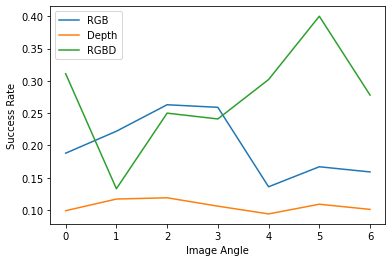

In [24]:
plt.plot(rgb_win, label = 'RGB')
plt.plot(depth_win, label = 'Depth')
plt.plot(rgbd_win, label = 'RGBD')
plt.legend(loc = 'best')
plt.xlabel('Image Angle')
plt.ylabel('Success Rate')